<a href="https://colab.research.google.com/github/manukala6/processing/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [0]:
import os
import ee
import numpy as np
import matplotlib.pyplot as plt       
from sklearn.linear_model import LinearRegression
from osgeo import gdal
from osgeo import osr

**Authenticate and Initialize**

In [0]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/twGJsnp5lywmjE71ql2Jh-WpZzEzChbTRVJRfwUTq1kJp8gidvAwVEE

Successfully saved authorization token.


In [0]:
ee.Initialize()

**Collect Imagery from Assets**

In [0]:
# links to earth engine image assets
naiman_image_links = [
  'users/manukala6/naimanResiduals/naimanResiduals1985',
  'users/manukala6/naimanResiduals/naimanResiduals1986',
  'users/manukala6/naimanResiduals/naimanResiduals1987',
  'users/manukala6/naimanResiduals/naimanResiduals1988',
  'users/manukala6/naimanResiduals/naimanResiduals1989',
  'users/manukala6/naimanResiduals/naimanResiduals1991',
  'users/manukala6/naimanResiduals/naimanResiduals1992',
  'users/manukala6/naimanResiduals/naimanResiduals1993',
  'users/manukala6/naimanResiduals/naimanResiduals1994',
  'users/manukala6/naimanResiduals/naimanResiduals1995',
  'users/manukala6/naimanResiduals/naimanResiduals1996',
  'users/manukala6/naimanResiduals/naimanResiduals1997',
  'users/manukala6/naimanResiduals/naimanResiduals1998',
  'users/manukala6/naimanResiduals/naimanResiduals1999',
  'users/manukala6/naimanResiduals/naimanResiduals2000',
  'users/manukala6/naimanResiduals/naimanResiduals2001',
  'users/manukala6/naimanResiduals/naimanResiduals2002',
  'users/manukala6/naimanResiduals/naimanResiduals2003',
  'users/manukala6/naimanResiduals/naimanResiduals2004',
  'users/manukala6/naimanResiduals/naimanResiduals2005']

# earth engine geometry of study area
study_area = ee.Geometry.Polygon(
        [[[120.58601753616483, 43.18954310017519],
          [120.58601753616483, 43.091842417767054],
          [120.7322730293289, 43.091842417767054],
          [120.7322730293289, 43.18954310017519]]])

In [0]:
naiman_images = []
for image_link in naiman_image_links:
  naiman_images.append(ee.Image(image_link))

**Create an array of shape** `(num_years, num_bands, num_rows, num_cols)`

---



In [0]:
def convert_ee2arr (ee_image):
  # define the image
  test_img = ee.Image('users/manukala6/naimanResiduals/naimanResiduals1987')
  # get the lat lon and add the ndvi
  latlon = ee.Image.pixelLonLat().addBands(test_img)
  # apply reducer to list
  latlon = latlon.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=study_area,
    maxPixels=1e8,
    scale=20);
  # get data into three different arrays
  ndvi = np.array((ee.Array(latlon.get("ndviCalendar")).getInfo()))
  prec = np.array((ee.Array(latlon.get('precipitation')).getInfo()))
  lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
  lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
  # get the unique coordinates
  uniqueLats = np.unique(lats)
  uniqueLons = np.unique(lons)
  # get number of columns and rows from coordinates
  ncols = len(uniqueLons)   
  nrows = len(uniqueLats)
  # determine pixelsizes
  ys = uniqueLats[1] - uniqueLats[0]
  xs = uniqueLons[1] - uniqueLons[0]
  # create an array with dimensions of image
  ndvi_arr = np.zeros([nrows, ncols], np.float32) #-9999
  prec_arr = np.zeros([nrows, ncols], np.float32) #-9999
  # fill the array with values
  counter = 0
  for y in range(0, ndvi_arr.shape[0], 1):
      for x in range(0, ndvi_arr.shape[1], 1):
          if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
              counter += 1
              ndvi_arr[len(uniqueLats)-1-y, x] = ndvi[counter] # start from lower left corner
              prec_arr[len(uniqueLats)-1-y, x] = prec[counter] # start from lower left corner
  # stack ndvi and precipitation
  return np.stack((ndvi_arr, prec_arr))

In [0]:
# do the thing
naiman_arr_images = []
for i in range(0, 19):
  naiman_arr_images.append(convert_ee2arr(naiman_images[i]))

In [0]:
# stack into one array of shape len(naiman_images)
naiman_arr = np.asarray(naiman_arr_images)

In [97]:
# check the shape
print('number of years: ', naiman_arr.shape[0])
print('number of bands: ', naiman_arr.shape[1])
print('number of cols:  ', naiman_arr.shape[2])
print('number of rows:  ', naiman_arr.shape[3])

number of years:  19
number of bands:  2
number of cols:   544
number of rows:   814


**Image Verification**

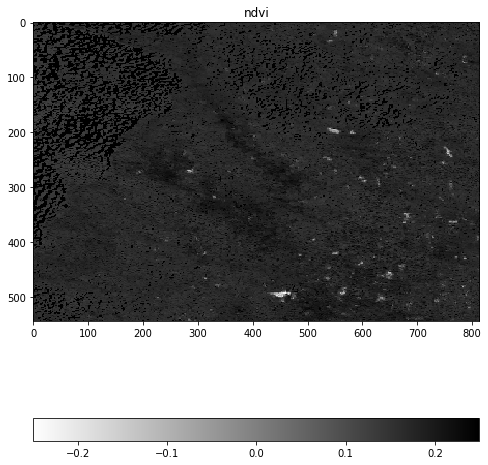

In [106]:
# select year 4 (1989), band 0 (ndvi)
test_img = naiman_arr[0, 0]

# plot image
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(test_img, cmap=plt.get_cmap('binary'))
imgplot.set_clim(-0.25, 0.25)
ax.set_title('ndvi')
plt.colorbar(orientation='horizontal')

**Regression**

In [0]:
# obtain ndvi band only
ndvi = naiman_arr[:,0]

# verify shape
ndvi.shape

(15, 543, 362)

In [0]:
# append slope per pixel into nd array
slopes = np.array([])
for row in range(300):
  for col in range(300):
    x = np.arange(15).reshape((-1,1))
    y = ndvi[:,col,row]
    model = LinearRegression().fit(x, y)
    slopes = np.append(slopes,model.coef_[0])

In [0]:
# verify shape
slopes = slopes.reshape((300,300))
slopes.shape

(300, 300)

In [0]:
x = np.asarray([0,1,2,3,4]).reshape((-1,1))
y = ndvi[:,0,0]

model = LinearRegression().fit(x, y)

# slope for this pixel
slope = model.coef_[0]
print(slope)

0.015169249475002297


**Save as GeoTIFF**

---



In [0]:
# config
INPUT_ARR = naiman_arr[0,0]
upper_left_tuple = (120.58601753616483, 43.18954310017519)
# create gdal data source raster object
gdal_driver = gdal.GetDriverByName('GTiff')
output_raster = gdal_driver.Create('sample_raster_12.tif', int(INPUT_ARR.shape[1]), int(INPUT_ARR.shape[0]), 1, gdal.GDT_Float64)
geotransform = (upper_left_tuple[0], 30, upper_left_tuple[1] + 30, -1 *(30), 0, 0)
spatial_reference = osr.SpatialReference()
spatial_reference.ImportFromEPSG(4326)
output_raster.SetProjection(spatial_reference.ExportToWkt())
output_raster.SetGeoTransform(geotransform)
output_band = output_raster.GetRasterBand(1)
output_band.SetNoDataValue(15)
output_band.WriteArray(INPUT_ARR)          
output_band.FlushCache()
output_band.ComputeStatistics(False)
output_raster

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fcc666c8bd0> >

In [0]:
output_raster.GetLayerCount()

0